In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import json
import os
import shutil
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [2]:
phaseLags = [0.6 * np.pi]  # 0.6, 0.9
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10
strengthKs = np.linspace(4, 20, 19)
distanceD0s = np.linspace(0.3, 1.1, 19)  
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [104]:
phaseLags = [0.6 * np.pi]  # 0.6, 0.9
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10 
strengthKs = np.linspace(1, 20, 19)
distanceD0s = np.linspace(0.1, 3, 19)  
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]
models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [105]:
savePath = (
    f"last_state/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

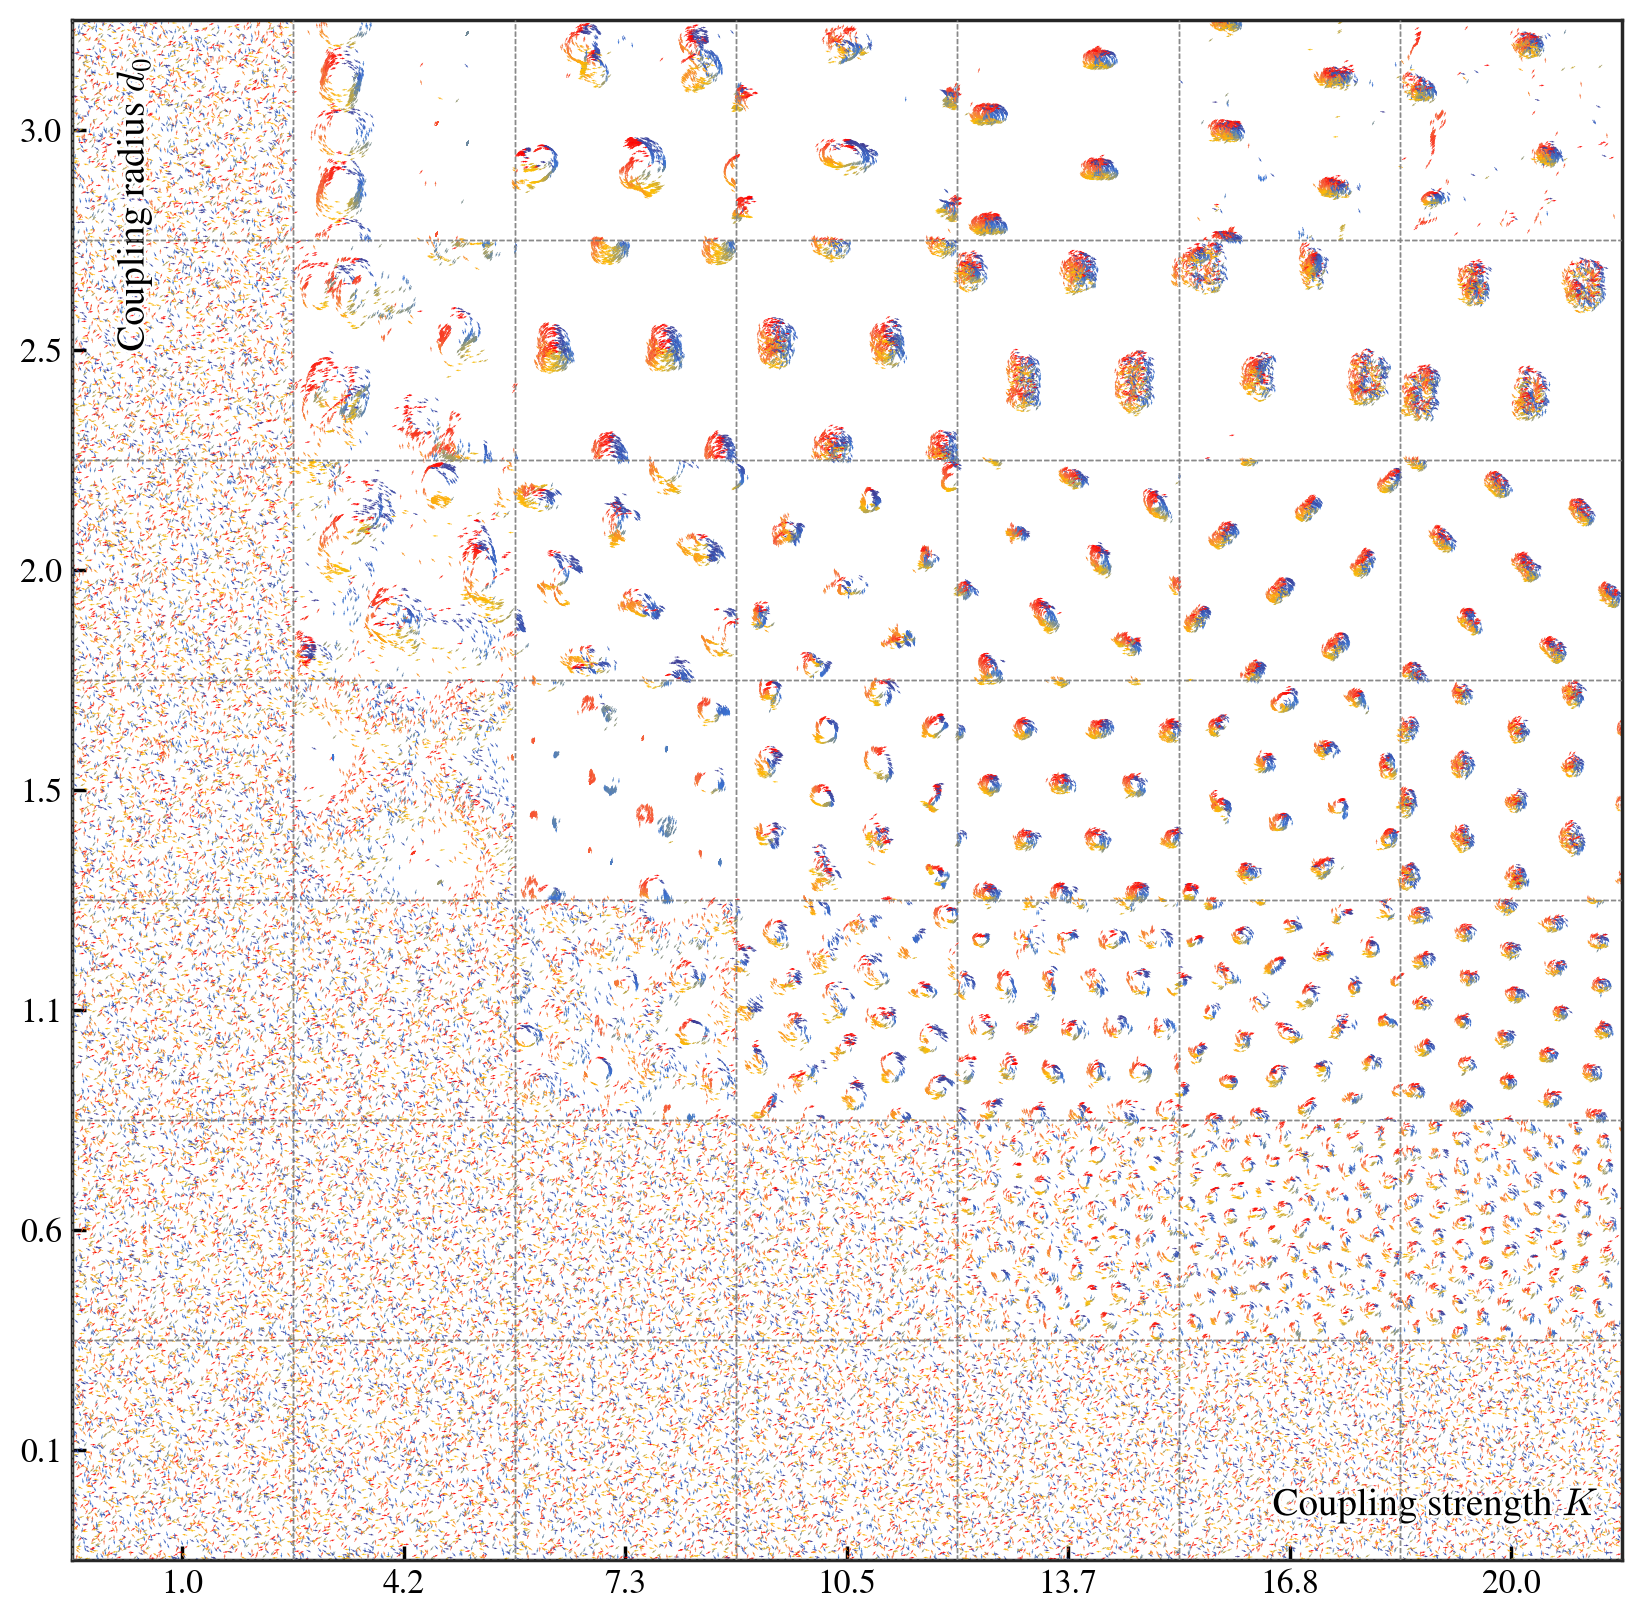

In [106]:
from matplotlib.patheffects import withStroke

colParams = distanceD0s[::3]
rowParams = strengthKs[::3]
colorsBy = "phase"

# fig, ax = plt.subplots(figsize=(len(rowParams) * 4, len(colParams) * 4))
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(len(colParams) * len(rowParams)):
    row = i // len(rowParams)
    col = i % len(rowParams)
    sa = [sa for sa in sas 
          if (sa.model.strengthK == rowParams[row]) and
             (sa.model.distanceD0 == colParams[col])][0]
    
    positionShift = np.array([row, col]) * sa.model.boundaryLength
    positionX, phaseTheta = sa.get_state(-1)
    positionX = positionX + positionShift
    if colorsBy == "freq":
        colors = (
            ["red"] * (sa.model.freqOmega >= 0).sum() + 
            ["#414CC7"] * (sa.model.freqOmega < 0).sum()
        )
    elif colorsBy == "phase":
        colors = [cmap(i) for i in
            np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
        ]

    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta), 
        color=colors,
        scale=300, width=0.0004 / len(rowParams) * 7
    )
    ax.axhline(
        y=col * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )
    ax.axvline(
        x=row * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )

boundaryLength = models[0].boundaryLength
plt.xlim(0, len(rowParams) * boundaryLength)
plt.ylim(0, len(colParams) * boundaryLength)
plt.xticks(
    np.arange(0, len(rowParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{k:.1f}" for k in rowParams]
)
plt.yticks(
    np.arange(0, len(colParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{d:.1f}" for d in colParams]
)

text1 = plt.text(len(rowParams) * boundaryLength * 0.88, len(rowParams) * boundaryLength * 0.035,
                 "Coupling strength $K$", # weight="bold",
                 fontsize=14, ha="center", va="center")
text2 = plt.text(len(rowParams) * boundaryLength * 0.04, len(rowParams) * boundaryLength * 0.88,
                 "Coupling radius $d_0$", # weight="bold",
                 fontsize=14, ha="center", va="center", rotation=90)
for text in [text1, text2]:
    text.set_path_effects([withStroke(linewidth=2, foreground='white')])
plt.tick_params(length=5, direction="in")
# plt.savefig(
#     f"figs/{sa.model.__class__.__name__}_"
#     f"varying_strengthK_and_distanceD0_{colorsBy}_"
#     f"a{phaseLags[0]:.2f}_Do{deltaOmegas[0]}"
#     f"{'initPhaseTheta,' if sa.model.initPhaseTheta is not None else ''}"
#     f"_aN{sa.model.agentsNum}_dist{sa.model.freqDist}.png", 
#     bbox_inches="tight"
# )

In [85]:
np.random.seed(5)
population = 10000
positionX = np.random.rand(population, 2) * sa.model.boundaryLength
r0 = sa.model.boundaryLength / np.sqrt(population)
distances = sa.calc_replative_distance(positionX, positionX[:, np.newaxis])
distances = (distances + np.eye(distances.shape[0]) * sa.model.boundaryLength)
dsI = distances.min(axis=1) / r0

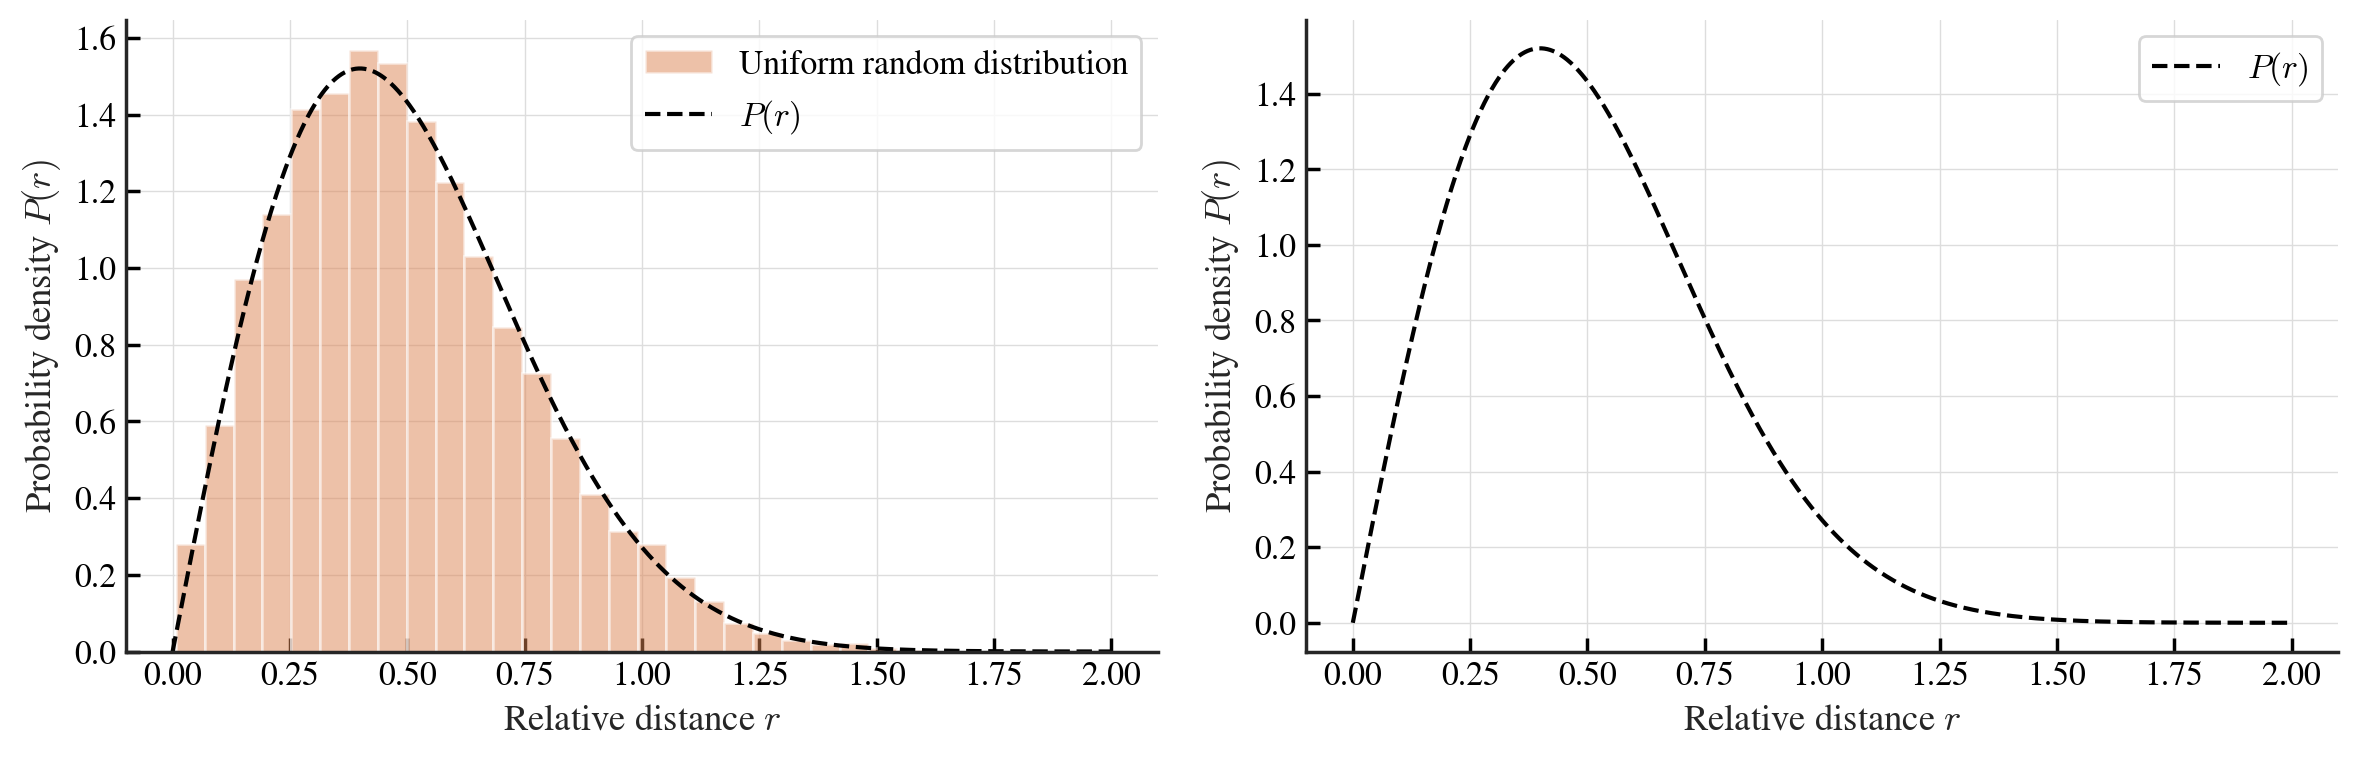

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs

ax1.hist(dsI, density=True, bins=30, alpha=0.5, color="C1", label="Uniform random distribution")

# for (d0, K), dsF in totalDsF.items():
#     ax2.hist(dsF, density=True, bins=50, histtype='step', lw=2, label=f"$d_0={d0:.2f}, K={K:.2f}$")

rs = np.linspace(0, 2, 1000)
Pr = 2*np.pi*rs * np.exp(-np.pi * rs**2)
for ax in axs:
    ax.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")
    ax.legend()
    ax.tick_params(length=5, direction="in")
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Relative distance $r$")
    ax.set_ylabel("Probability density $P(r)$")

plt.tight_layout()
# plt.savefig("figs/uniform.pdf", bbox_inches="tight")

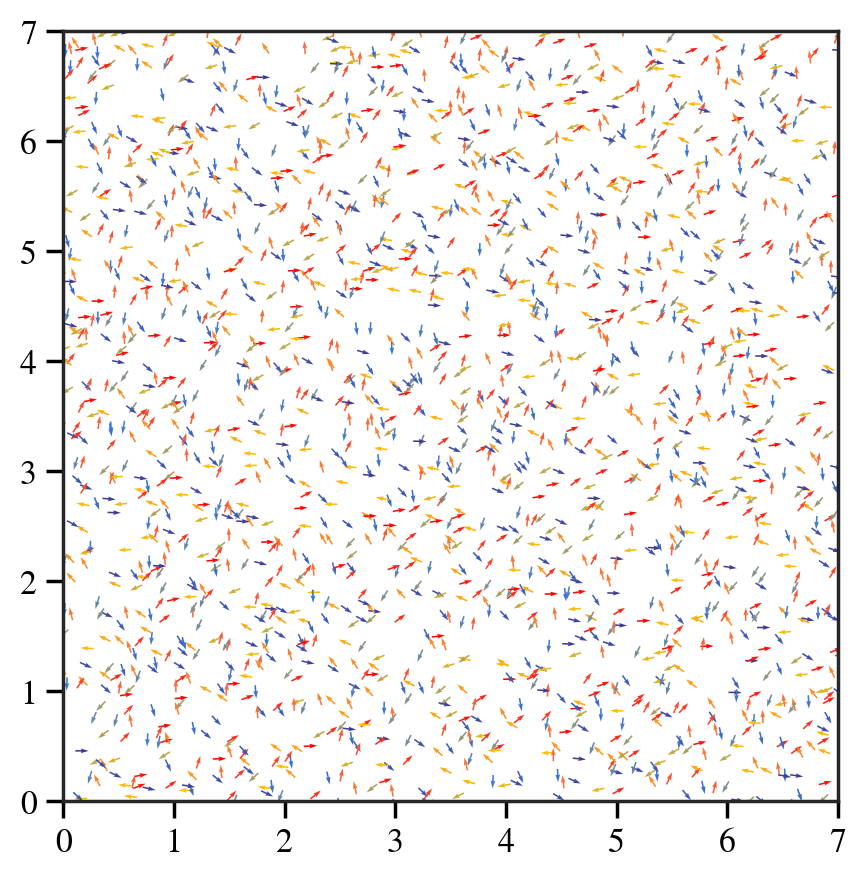

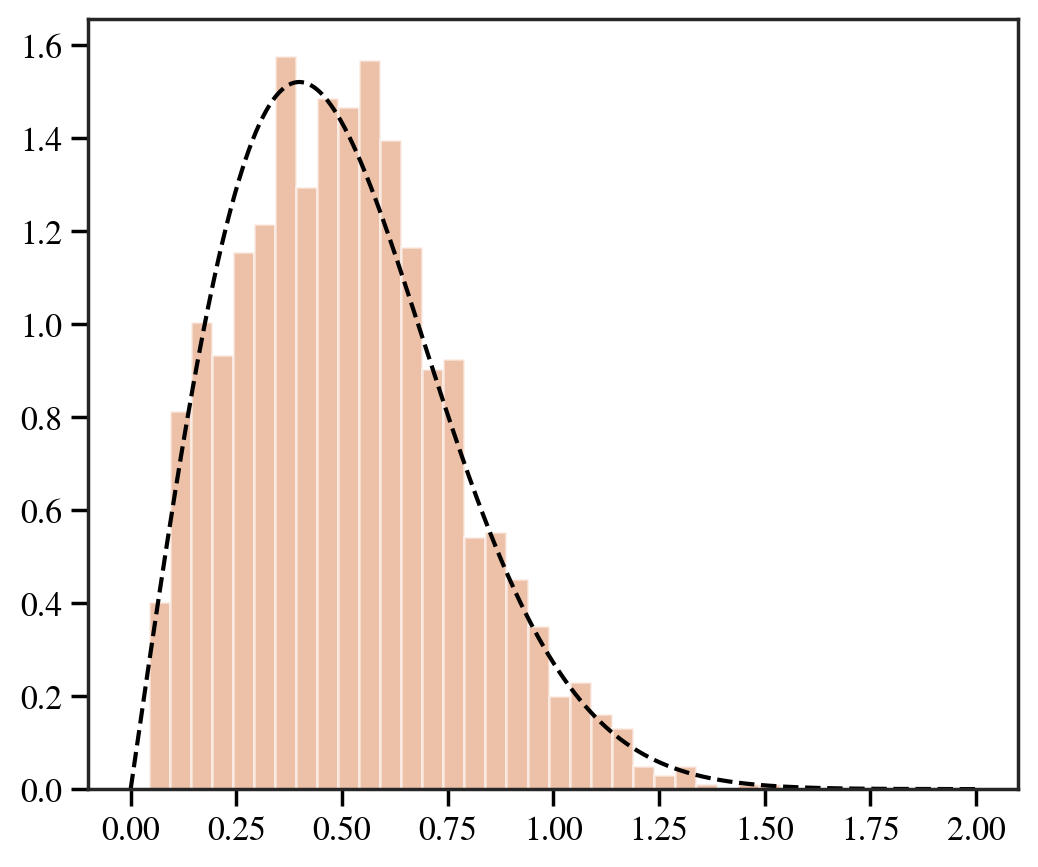

In [115]:
d0, K = 0.1, 20
sa: StateAnalysis = [sa for sa in sas if sa.model.distanceD0 == d0 and sa.model.strengthK == K][0]
sa.plot_spatial()
plt.show()

r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
dsF = sa.calc_replative_distance(sa.totalPositionX[-1], sa.totalPositionX[-1][:, np.newaxis])
dsF[dsF == 0] = np.inf
dsF = dsF.min(axis=0) / r0
plt.hist(dsF, density=True, bins=30, alpha=0.5, color="C1")
plt.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")

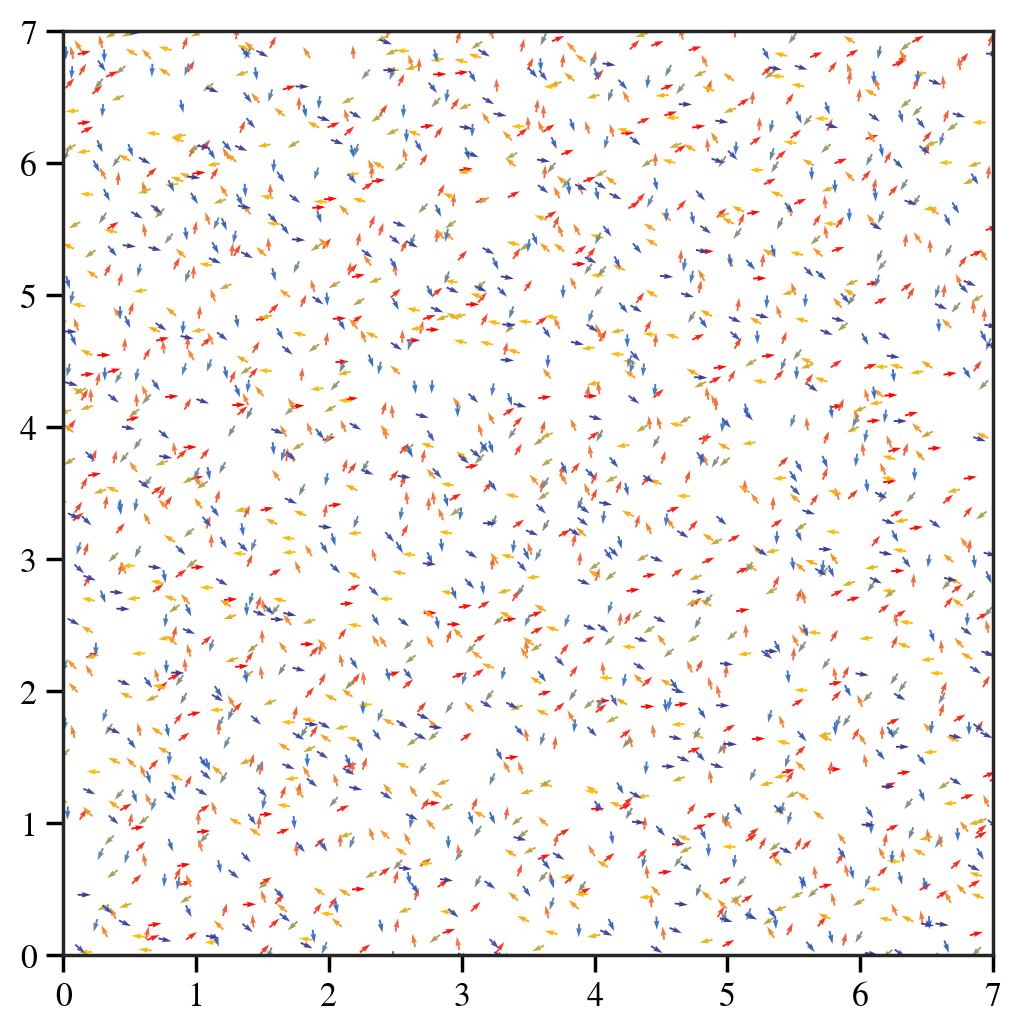

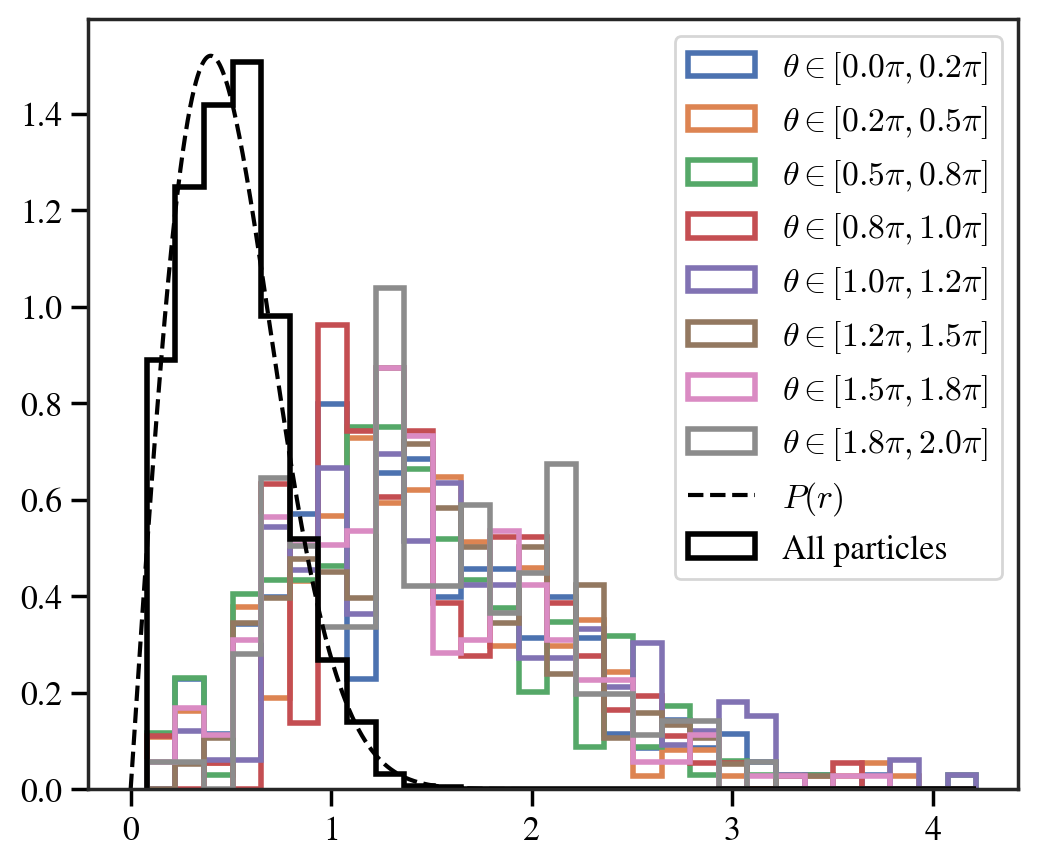

In [154]:
positionX, phaseTheta = sa.get_state(-1)
splitPhaseBin = np.linspace(0, 2 * np.pi, 9)
selectIdxs = np.digitize(phaseTheta, splitPhaseBin) - 1
selectIdxs = [
    np.where(selectIdxs == i)[0] for i in range(len(splitPhaseBin) - 1)
]
dsFDict = {}

plt.figure(figsize=(6, 6))
for i, idxs in enumerate(selectIdxs):
    subPositionX = positionX[idxs]
    subPhaseTheta = phaseTheta[idxs]
    colors = [cmap(i) for i in
        np.floor(256 - subPhaseTheta / (2 * np.pi) * 256).astype(np.int32)
    ]
    # plt.figure(figsize=(6, 6))
    plt.quiver(
        subPositionX[:, 0], subPositionX[:, 1],
        np.cos(subPhaseTheta), np.sin(subPhaseTheta),
        scale_units='inches', scale=15.0, width=0.002,
        color=colors
    )
    plt.xlim(0, sa.model.boundaryLength)
    plt.ylim(0, sa.model.boundaryLength)
    # plt.show()

    r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
    dsF = sa.calc_replative_distance(subPositionX, subPositionX[:, np.newaxis])
    dsF[dsF == 0] = np.inf
    dsF = dsF.min(axis=0) / r0

    dsFDict[i] = dsF

plt.show()

all_data = np.concatenate(list(dsFDict.values()) + [dsF])
min_val, max_val = np.min(all_data), np.max(all_data)

bins = np.linspace(min_val, max_val, 30)

for i, dsF in dsFDict.items():
    plt.hist(dsF, density=True, bins=bins, histtype='step', lw=2, 
             label=r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi))

plt.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")

r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
dsF = sa.calc_replative_distance(sa.totalPositionX[-1], sa.totalPositionX[-1][:, np.newaxis])
dsF[dsF == 0] = np.inf
dsF = dsF.min(axis=0) / r0
plt.hist(dsF, density=True, bins=bins, alpha=1, color="black", histtype='step', lw=2, label="All particles")
plt.legend()

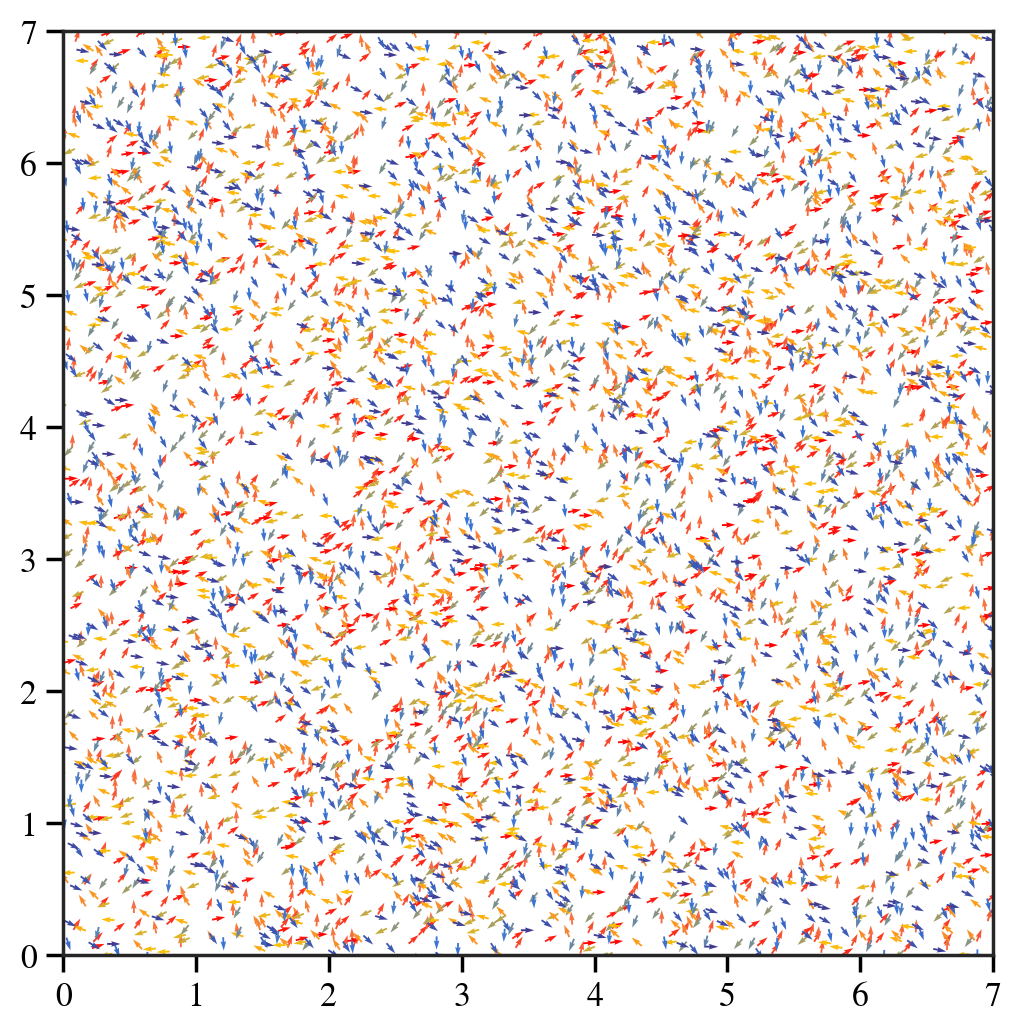

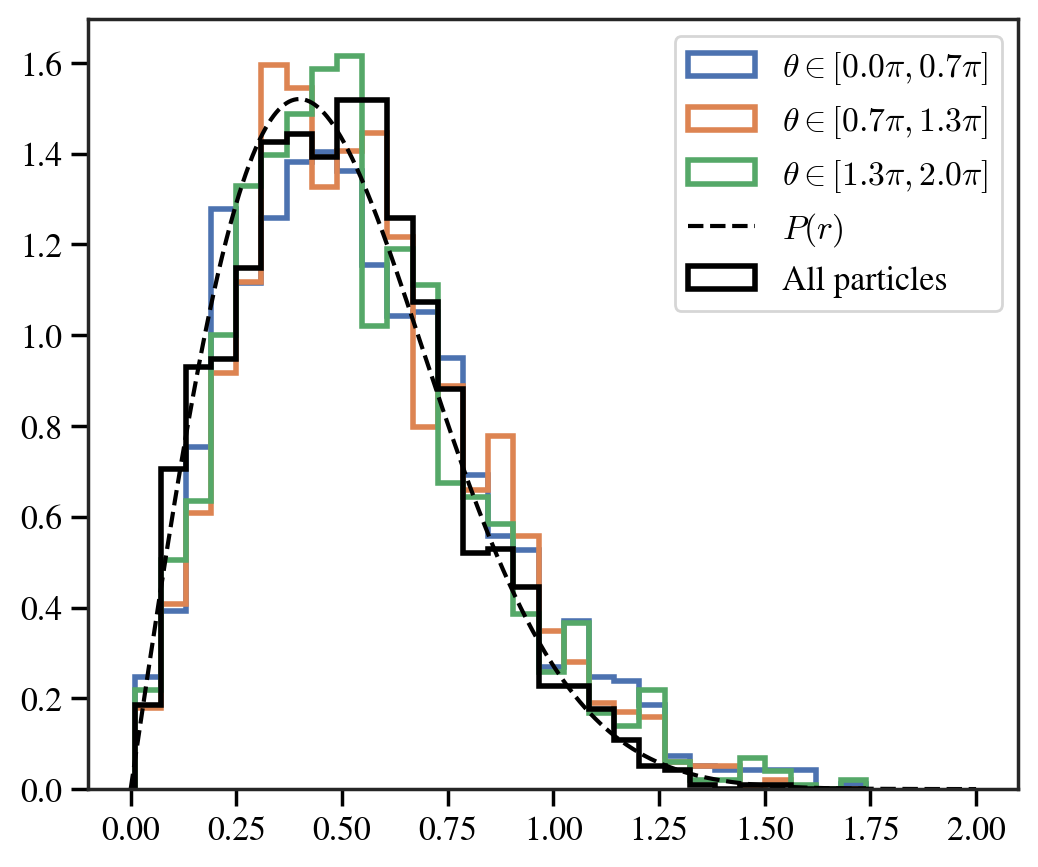

In [158]:
np.random.seed(5)
population = 5000
positionX = np.random.rand(population, 2) * sa.model.boundaryLength
phaseTheta = np.random.rand(population) * 2 * np.pi
splitPhaseBin = np.linspace(0, 2 * np.pi, 4)
selectIdxs = np.digitize(phaseTheta, splitPhaseBin) - 1
selectIdxs = [
    np.where(selectIdxs == i)[0] for i in range(len(splitPhaseBin) - 1)
]
dsFDict = {}

plt.figure(figsize=(6, 6))
for i, idxs in enumerate(selectIdxs):
    subPositionX = positionX[idxs]
    subPhaseTheta = phaseTheta[idxs]
    colors = [cmap(i) for i in
        np.floor(256 - subPhaseTheta / (2 * np.pi) * 256).astype(np.int32)
    ]
    # plt.figure(figsize=(6, 6))
    plt.quiver(
        subPositionX[:, 0], subPositionX[:, 1],
        np.cos(subPhaseTheta), np.sin(subPhaseTheta),
        scale_units='inches', scale=15.0, width=0.002,
        color=colors
    )
    plt.xlim(0, sa.model.boundaryLength)
    plt.ylim(0, sa.model.boundaryLength)
    # plt.show()

    r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
    dsF = sa.calc_replative_distance(subPositionX, subPositionX[:, np.newaxis])
    dsF[dsF == 0] = np.inf
    dsF = dsF.min(axis=0) / r0

    dsFDict[i] = dsF

plt.show()

all_data = np.concatenate(list(dsFDict.values()) + [dsF])
min_val, max_val = np.min(all_data), np.max(all_data)

bins = np.linspace(min_val, max_val, 30)

for i, dsF in dsFDict.items():
    plt.hist(dsF, density=True, bins=bins, histtype='step', lw=2, 
             label=r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi))

plt.plot(rs, Pr, color="black", linewidth=1.5, label="$P(r)$", ls="--")

r0 = sa.model.boundaryLength / np.sqrt(sa.model.agentsNum)
dsF = sa.calc_replative_distance(sa.totalPositionX[-1], sa.totalPositionX[-1][:, np.newaxis])
dsF[dsF == 0] = np.inf
dsF = dsF.min(axis=0) / r0
plt.hist(dsF, density=True, bins=bins, alpha=1, color="black", histtype='step', lw=2, label="All particles")
plt.legend()